## Load Libraries and Set-up Parameters

In [2]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

# -------------------------
# 1. Set Up Parameters
# -------------------------
T = 365  # Number of days available for ticket sales (horizon)
coach_capacity = 100
overbook = 5
coach_max = coach_capacity + overbook  # Maximum coach tickets sold (105 for this iteration)
fc_capacity = 20  # First-class capacity (no overbooking allowed)

# Ticket prices and base sale probabilities (if not adjusted)
coach_prices = [300, 350]
fc_prices = [425, 500]
# Base probabilities for coach sales at given prices
coach_probs = {300: 0.65, 350: 0.30}  # (if first-class is sold out, add 0.03)
# Base probabilities for first-class sales at given prices
fc_probs = {425: 0.08, 500: 0.04}

# Show-up probabilities (no-show probabilities affect terminal costs)
coach_show = 0.95
fc_show = 0.97

# Overbooking cost parameters
cost_bump_fc = 50    # Cost to bump a coach passenger up to first-class
cost_bump_off = 425  # Cost to bump a coach passenger off the plane

# Daily discount factor, given a 17% annual discount rate
beta = 1 / (1 + 0.17 / 365)


# Question 1 Code

In [5]:
# -------------------------
# 2. Initialize DP Arrays
# -------------------------
# V[n, cs, fs] will hold the value function (expected discounted profit) 
# with n days remaining, cs coach tickets sold, and fs first-class tickets sold.
# We use dimensions: (T+1) x (coach_max+1) x (fc_capacity+1)
V = np.zeros((T + 1, coach_max + 1, fc_capacity + 1))
policy = np.empty((T + 1, coach_max + 1, fc_capacity + 1), dtype=object)

# -------------------------
# 3. Terminal Value (Flight Day)
# -------------------------
# When no days remain (n=0), no further revenue is collected.
# Instead, the airline incurs costs from overbooking.
# We calculate the expected overbooking cost by considering the binomial
# probabilities for the number of passengers that show up.
for cs in range(coach_max + 1):
    for fs in range(fc_capacity + 1):
        expected_cost = 0
        # Sum over all possible numbers of coach passengers showing up.
        for x in range(cs + 1):
            p_x = binom.pmf(x, cs, coach_show)
            # Sum over all possible numbers of first-class passengers showing up.
            for y in range(fs + 1):
                p_y = binom.pmf(y, fs, fc_show)
                # Compute how many extra coach passengers appear beyond available coach seats.
                extra = max(x - coach_capacity, 0)
                # Available first-class seats (if fc passengers don’t show up)
                available_fc = max(fc_capacity - y, 0)
                # Bump as many extra coach passengers as possible into available fc seats.
                bumped_to_fc = min(extra, available_fc)
                bumped_off = extra - bumped_to_fc
                cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                expected_cost += p_x * p_y * cost
        V[0, cs, fs] = -expected_cost  # Terminal reward is negative cost



In [6]:
# -------------------------
# 4. Backward Induction DP
# -------------------------
# For n = 1 to T (days remaining), we choose optimal prices.
# The state is (n, cs, fs). On each day, two independent decisions are made:
# one for coach and one for first-class.
for n in range(1, T + 1):
    for cs in range(coach_max + 1):
        for fs in range(fc_capacity + 1):
            best_value = -np.inf
            best_decision = None
            # Loop over coach pricing options.
            for cp in coach_prices:
                # If maximum coach tickets have been sold, no further sale is possible.
                if cs == coach_max:
                    p_c = 0
                else:
                    p_c = coach_probs[cp]
                    # Increase probability by 3 percentage points if first-class is sold out.
                    if fs == fc_capacity:
                        p_c += 0.03
                # Loop over first-class pricing options.
                for fp in fc_prices:
                    # If first-class capacity is reached, no sale occurs.
                    if fs == fc_capacity:
                        p_f = 0
                    else:
                        p_f = fc_probs[fp]
                    # Immediate expected revenue from today:
                    # By linearity of expectation, add coach and first-class revenues.
                    immediate_revenue = p_c * cp + p_f * fp
                    # Next-state transitions:
                    # - No sale: state remains (cs, fs) with probability (1-p_c)*(1-p_f)
                    # - Coach sale only: state becomes (cs+1, fs) with probability p_c*(1-p_f)
                    # - First-class sale only: state becomes (cs, fs+1) with probability (1-p_c)*p_f
                    # - Both sales: state becomes (cs+1, fs+1) with probability p_c*p_f
                    v_no_sale = V[n - 1, cs, fs]
                    v_coach_sale = V[n - 1, min(cs + 1, coach_max), fs]
                    v_fc_sale = V[n - 1, cs, min(fs + 1, fc_capacity)]
                    v_both = V[n - 1, min(cs + 1, coach_max), min(fs + 1, fc_capacity)]
                    expected_future_value = ((1 - p_c) * (1 - p_f) * v_no_sale +
                                              p_c * (1 - p_f) * v_coach_sale +
                                              (1 - p_c) * p_f * v_fc_sale +
                                              p_c * p_f * v_both)
                    # Total value for the day if these prices are chosen:
                    value = immediate_revenue + beta * expected_future_value
                    # Check if this decision is better.
                    if value > best_value:
                        best_value = value
                        best_decision = (cp, fp)
            V[n, cs, fs] = best_value
            policy[n, cs, fs] = best_decision


In [7]:

# -------------------------
# 5. Report the Result
# -------------------------
# Starting from state (0 coach sold, 0 fc sold) with T days remaining,
# print the optimal expected discounted profit.
print("Optimal expected discounted profit (with 5 overbooked seats):", V[T, 0, 0])

Optimal expected discounted profit (with 5 overbooked seats): 41886.1586241959


## Question 1 Graphs

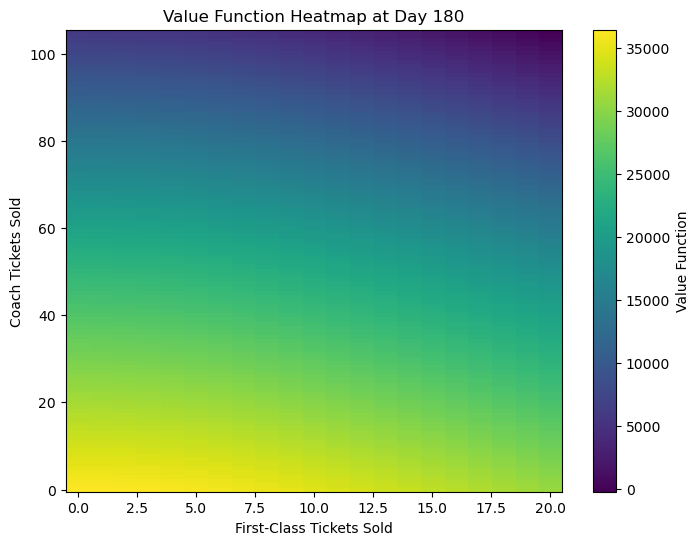

In [16]:
# Choose a time slice (e.g., day 182)
time_step = 180
value_slice = V[time_step, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(value_slice, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Value Function')
plt.ylabel('Coach Tickets Sold')
plt.xlabel('First-Class Tickets Sold')
plt.title(f'Value Function Heatmap at Day {time_step}')
plt.show()

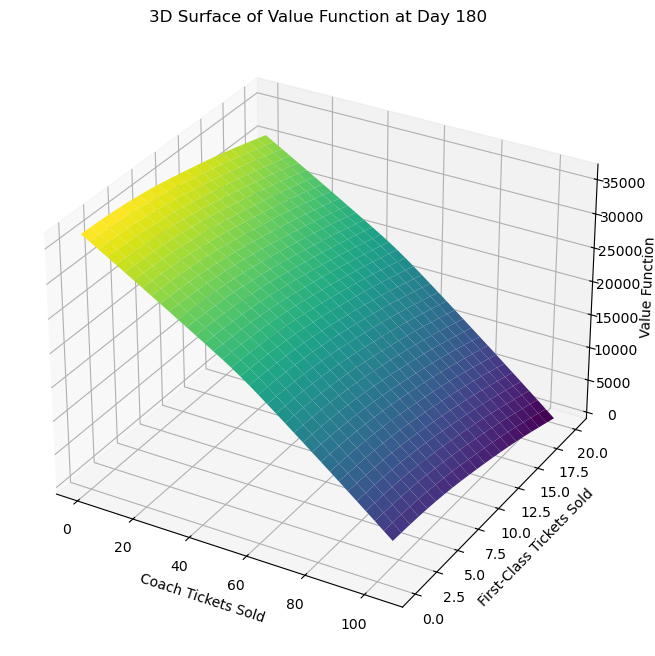

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

cs = np.arange(coach_max + 1)
fs = np.arange(fc_capacity + 1)
cs_grid, fs_grid = np.meshgrid(cs, fs)
value_slice = V[time_step, :, :]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(cs_grid, fs_grid, value_slice.T, cmap='viridis')
ax.set_xlabel('Coach Tickets Sold')
ax.set_ylabel('First-Class Tickets Sold')
ax.set_zlabel('Value Function')
ax.set_title(f'3D Surface of Value Function at Day {time_step}')
plt.show()

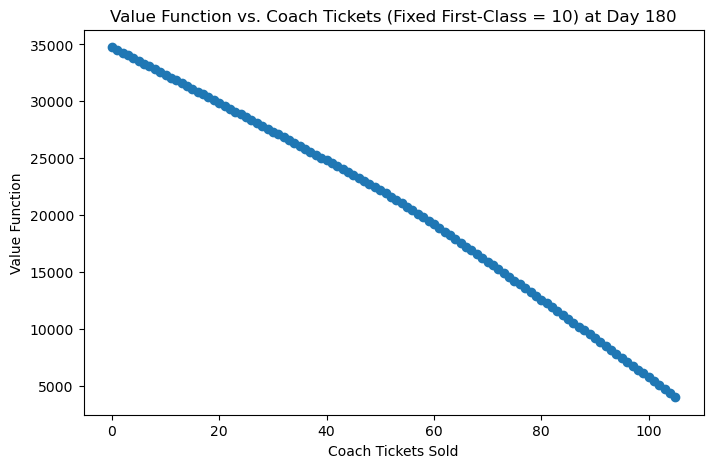

In [18]:
fixed_fs = 10  # fixed first-class tickets sold
values_vs_coach = V[time_step, :, fixed_fs]

plt.figure(figsize=(8, 5))
plt.plot(np.arange(coach_max + 1), values_vs_coach, marker='o')
plt.xlabel('Coach Tickets Sold')
plt.ylabel('Value Function')
plt.title(f'Value Function vs. Coach Tickets (Fixed First-Class = {fixed_fs}) at Day {time_step}')
plt.show()

# Question 2: Overbooking scenarios

Overbooking by 5 seats: Optimal Expected Discounted Profit = 41886.16
Overbooking by 6 seats: Optimal Expected Discounted Profit = 42011.22
Overbooking by 7 seats: Optimal Expected Discounted Profit = 42085.54
Overbooking by 8 seats: Optimal Expected Discounted Profit = 42122.17
Overbooking by 9 seats: Optimal Expected Discounted Profit = 42134.62
Overbooking by 10 seats: Optimal Expected Discounted Profit = 42132.90
Overbooking by 11 seats: Optimal Expected Discounted Profit = 42123.67
Overbooking by 12 seats: Optimal Expected Discounted Profit = 42111.03
Overbooking by 13 seats: Optimal Expected Discounted Profit = 42097.42
Overbooking by 14 seats: Optimal Expected Discounted Profit = 42084.11
Overbooking by 15 seats: Optimal Expected Discounted Profit = 42071.74


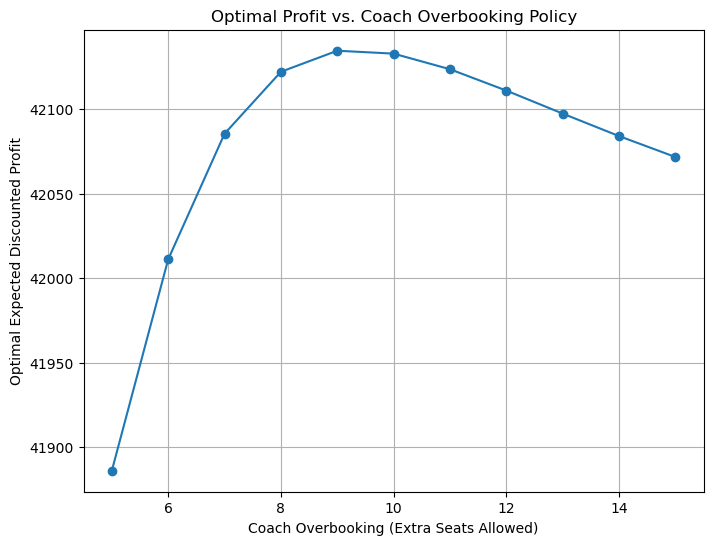

In [20]:
# -------------------------
# 1. Define the Parameters
# -------------------------
T = 365                      # Number of days to sell tickets
coach_capacity = 100         # Coach seating capacity (base)
fc_capacity = 20             # First-class seating capacity (no overbooking allowed)
coach_prices = [300, 350]    # Two coach ticket prices
fc_prices = [425, 500]       # Two first-class ticket prices
coach_probs = {300: 0.65, 350: 0.30}  # Base sale probabilities for coach tickets
fc_probs = {425: 0.08, 500: 0.04}     # Base sale probabilities for first-class tickets
coach_show = 0.95            # Probability a coach ticket holder shows up
fc_show = 0.97               # Probability a first-class ticket holder shows up
cost_bump_fc = 50            # Cost to bump a coach passenger to first-class
cost_bump_off = 425          # Cost to bump a coach passenger off the flight
beta = 1 / (1 + 0.17 / 365)  # Daily discount factor

# -------------------------
# 2. DP Function for a Given Overbooking Policy
# -------------------------
def solve_dp(overbook):
    """
    Solves the dynamic programming problem for a given coach overbooking policy.
    overbook: extra seats allowed beyond the coach_capacity.
    Returns the optimal expected discounted profit from state (0,0) after T days.
    """
    coach_max = coach_capacity + overbook  # Maximum coach tickets sold
    # Initialize the value function array.
    # Dimensions: (T+1) x (coach_max+1) x (fc_capacity+1)
    V = np.zeros((T + 1, coach_max + 1, fc_capacity + 1))
    
    # Terminal state: when T days are over, only costs occur.
    for cs in range(coach_max + 1):
        for fs in range(fc_capacity + 1):
            expected_cost = 0.0
            # Sum over possible numbers of coach passengers showing up.
            for x in range(cs + 1):
                p_x = binom.pmf(x, cs, coach_show)
                # Sum over possible numbers of first-class passengers showing up.
                for y in range(fs + 1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)  # extra coach passengers over available seats
                    available_fc = max(fc_capacity - y, 0)  # available first-class seats
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost  # Terminal value is negative cost
    
    # Backward induction over T days
    for t in range(1, T + 1):
        for cs in range(coach_max + 1):
            for fs in range(fc_capacity + 1):
                best_value = -np.inf
                # Loop over possible pricing decisions.
                for cp in coach_prices:
                    # If maximum coach tickets sold, no sale can occur.
                    if cs == coach_max:
                        p_c = 0
                    else:
                        p_c = coach_probs[cp]
                        # If first-class is sold out, increase coach sale probability by 0.03.
                        if fs == fc_capacity:
                            p_c += 0.03
                    for fp in fc_prices:
                        # If first-class sold out, no first-class sale.
                        if fs == fc_capacity:
                            p_f = 0
                        else:
                            p_f = fc_probs[fp]
                        immediate_revenue = p_c * cp + p_f * fp
                        # Next state transitions (using min to ensure we don't exceed capacities):
                        v_no_sale = V[t - 1, cs, fs]
                        v_coach_sale = V[t - 1, min(cs + 1, coach_max), fs]
                        v_fc_sale = V[t - 1, cs, min(fs + 1, fc_capacity)]
                        v_both = V[t - 1, min(cs + 1, coach_max), min(fs + 1, fc_capacity)]
                        expected_future = ((1 - p_c) * (1 - p_f) * v_no_sale +
                                           p_c * (1 - p_f) * v_coach_sale +
                                           (1 - p_c) * p_f * v_fc_sale +
                                           p_c * p_f * v_both)
                        total_value = immediate_revenue + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                V[t, cs, fs] = best_value
    return V[T, 0, 0]

# -------------------------
# 3. Evaluate Different Overbooking Policies and Collect Results
# -------------------------
overbook_values = list(range(5, 16))  # Testing overbook values from 5 to 15 seats
profits = []

for overbook in overbook_values:
    profit = solve_dp(overbook)
    profits.append(profit)
    print(f"Overbooking by {overbook} seats: Optimal Expected Discounted Profit = {profit:.2f}")

# -------------------------
# 4. Visualization: Plot Profit vs. Overbooking Policy
# -------------------------
plt.figure(figsize=(8, 6))
plt.plot(overbook_values, profits, marker='o')
plt.xlabel('Coach Overbooking (Extra Seats Allowed)')
plt.ylabel('Optimal Expected Discounted Profit')
plt.title('Optimal Profit vs. Coach Overbooking Policy')
plt.grid(True)
plt.show()

### Results with no Over-Book Policy Enabled

In [16]:
solve_dp(0)

40654.29428780592

# Question 3 : No Sale Option

No-sale policy with overbook=0: Profit = 40654.29
No-sale policy with overbook=5: Profit = 41886.16
No-sale policy with overbook=10: Profit = 42138.14
No-sale policy with overbook=15: Profit = 42139.89
No-sale policy with overbook=20: Profit = 42139.89
No-sale policy with overbook=25: Profit = 42139.89
No-sale policy with overbook=30: Profit = 42139.89
No-sale policy with overbook=35: Profit = 42139.89
No-sale policy with overbook=40: Profit = 42139.89
No-sale policy with overbook=45: Profit = 42139.89
No-sale policy with overbook=50: Profit = 42139.89


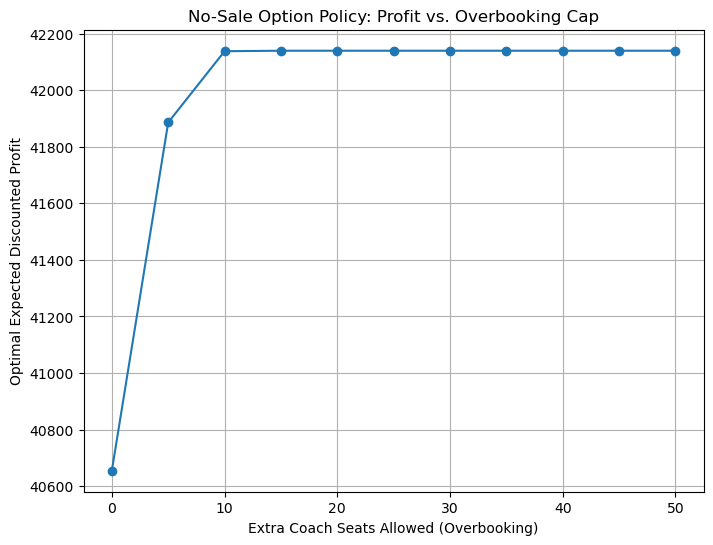

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# -------------------------
# Shared Parameters
# -------------------------
T = 365                      # Days until departure
coach_capacity = 100         # Physical capacity for coach seats
fc_capacity = 20             # First-class capacity (no overbooking)
# Coach pricing options: (label, price, base probability)
coach_options = [
    ('none', 0, 0.0),        # No sale option
    ('low', 300, 0.65),
    ('high', 350, 0.30)
]
# First-class pricing options: (label, price, base probability)
fc_options = [
    ('low', 425, 0.08),
    ('high', 500, 0.04)
]
# Show-up probabilities
coach_show = 0.95
fc_show = 0.97
# Overbooking costs (applied when coach show-ups exceed coach_capacity)
cost_bump_fc = 50    # Cost to bump a coach passenger to first-class
cost_bump_off = 425  # Cost to bump a coach passenger off the plane

# Daily discount factor given a 17% annual discount rate
beta = 1 / (1 + 0.17 / 365)

# -------------------------
# DP Function for No-Sale Option with Variable Cap
# -------------------------
def solve_dp_no_sale_with_cap(overbook):
    """
    Solves the dynamic programming problem for the no-sale option policy.
    overbook: extra seats allowed beyond the physical capacity (coach_capacity).
    The state tracks the number of coach tickets sold (0 to coach_capacity+overbook)
    and first-class tickets sold (0 to fc_capacity).
    Returns the optimal expected discounted profit from state (0,0) with T days remaining.
    """
    coach_max_new = coach_capacity + overbook  # Maximum allowed coach tickets sold
    # Initialize value function: dimensions: (T+1) x (coach_max_new+1) x (fc_capacity+1)
    V = np.zeros((T + 1, coach_max_new + 1, fc_capacity + 1))
    
    # Terminal stage: on flight day, no revenue is earned; instead, overbooking costs are incurred.
    for cs in range(coach_max_new + 1):
        for fs in range(fc_capacity + 1):
            expected_cost = 0.0
            # Sum over possible coach show-ups
            for x in range(cs + 1):
                p_x = binom.pmf(x, cs, coach_show)
                # Sum over possible first-class show-ups
                for y in range(fs + 1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)  # Excess coach passengers beyond physical capacity
                    available_fc = max(fc_capacity - y, 0)  # Available first-class seats
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost  # Terminal value (negative cost)
    
    # Backward induction over T days
    for t in range(1, T + 1):
        for cs in range(coach_max_new + 1):
            for fs in range(fc_capacity + 1):
                best_value = -np.inf
                # Evaluate all combinations of coach and first-class pricing options
                for (coach_dec, cp, base_p_c) in coach_options:
                    # If maximum coach tickets have been sold, no coach sale can occur.
                    if cs == coach_max_new:
                        p_c = 0.0
                    else:
                        # For the 'none' option, p_c is 0 and revenue is 0.
                        if coach_dec == 'none':
                            p_c = 0.0
                        else:
                            p_c = base_p_c
                            # When first-class is full, boost the coach sale probability by 0.03.
                            if fs == fc_capacity:
                                p_c += 0.03
                    for (fc_dec, fp, base_p_f) in fc_options:
                        if fs == fc_capacity:
                            p_f = 0.0
                        else:
                            p_f = base_p_f
                        # Immediate revenue: coach revenue only if sale occurs (if not 'none'),
                        # plus first-class revenue.
                        immediate_rev = p_c * cp + p_f * fp
                        
                        # Define state transitions:
                        # If a sale happens for coach (and not 'none'), cs increases by 1 (if not at cap).
                        new_cs = cs + 1 if (coach_dec != 'none' and cs < coach_max_new) else cs
                        # For first-class, if sale occurs, fs increases by 1 (up to fc_capacity).
                        new_fs = fs + 1 if (fs < fc_capacity) else fs
                        
                        # Next-state values for the four possible outcomes:
                        v_no_sale = V[t - 1, cs, fs]  # Neither sale occurs
                        v_coach_only = V[t - 1, new_cs, fs]  # Only coach sale occurs
                        v_fc_only = V[t - 1, cs, new_fs]      # Only fc sale occurs
                        v_both = V[t - 1, new_cs, new_fs]       # Both sales occur
                        
                        # Because the two sales are independent:
                        exp_future = ((1 - p_c) * (1 - p_f) * v_no_sale +
                                      p_c * (1 - p_f) * v_coach_only +
                                      (1 - p_c) * p_f * v_fc_only +
                                      p_c * p_f * v_both)
                        
                        total_value = immediate_rev + beta * exp_future
                        if total_value > best_value:
                            best_value = total_value
                V[t, cs, fs] = best_value
    return V[T, 0, 0]

# -------------------------
# 2. Run DP for Different Caps and Collect Results
# -------------------------
# overbook_options: extra seats allowed beyond 100, ranging from 5 to 50 in increments of 5.
overbook_options = list(range(0, 51, 5))
profits_no_sale = []

for overbook in overbook_options:
    profit = solve_dp_no_sale_with_cap(overbook)
    profits_no_sale.append(profit)
    print(f"No-sale policy with overbook={overbook}: Profit = {profit:.2f}")

# -------------------------
# 3. Visualization: Plot Profit vs. Overbooking Cap
# -------------------------
plt.figure(figsize=(8, 6))
plt.plot(overbook_options, profits_no_sale, marker='o', linestyle='-')
plt.xlabel('Extra Coach Seats Allowed (Overbooking)')
plt.ylabel('Optimal Expected Discounted Profit')
plt.title('No-Sale Option Policy: Profit vs. Overbooking Cap')
plt.grid(True)
plt.show()

# Question 4

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# -------------------------
# Shared Parameters
# -------------------------
T = 365                      # Total number of days until departure
coach_capacity = 100         # Physical capacity for coach seats
fc_capacity = 20             # First-class capacity (no overbooking allowed)

# Show-up probabilities (for terminal cost computation)
coach_show = 0.95
fc_show = 0.97

# Overbooking cost parameters
cost_bump_fc = 50    # Cost to bump a coach passenger to first-class
cost_bump_off = 425  # Cost to bump a coach passenger off the plane

# Daily discount factor (given a 17% annual discount rate)
beta = 1 / (1 + 0.17 / 365)

# Base pricing and sale probabilities (before seasonality adjustment)
# For coach:
coach_low_price = 300
coach_high_price = 350
coach_prob_low = 0.65
coach_prob_high = 0.30

# For first-class:
fc_low_price = 425
fc_high_price = 500
fc_prob_low = 0.08
fc_prob_high = 0.04

# -------------------------
# 1. Hard-Cap Policy DP with Seasonality
# -------------------------
def solve_dp_hardcap_with_seasonality(overbook):
    """
    Solves the DP problem for the hard-cap model (no no-sale option)
    with seasonality. 'overbook' is the extra coach seats allowed beyond
    coach_capacity. The state is defined as (days_remaining, coach tickets sold, fc tickets sold).
    """
    coach_max = coach_capacity + overbook
    V = np.zeros((T + 1, coach_max + 1, fc_capacity + 1))
    
    # Terminal stage: At departure (no days left), compute expected overbooking cost.
    for cs in range(coach_max + 1):
        for fs in range(fc_capacity + 1):
            expected_cost = 0.0
            # Sum over possible numbers of passengers showing up
            for x in range(cs + 1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs + 1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost

    # Backward induction over days.
    for t in range(1, T + 1):
        # Compute the current day number (1 is earliest, T is last day)
        day = T - t + 1  
        season_factor = 0.75 + day / 730.0
        
        for cs in range(coach_max + 1):
            for fs in range(fc_capacity + 1):
                best_value = -np.inf
                # Two coach pricing options: low and high.
                for (cp, base_p_c) in [(coach_low_price, coach_prob_low), (coach_high_price, coach_prob_high)]:
                    if cs == coach_max:
                        effective_p_c = 0.0
                    else:
                        # Boost coach sale probability if first-class is full.
                        if fs == fc_capacity:
                            effective_p_c = (base_p_c + 0.03) * season_factor
                        else:
                            effective_p_c = base_p_c * season_factor
                    # Two first-class pricing options.
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        if fs == fc_capacity:
                            effective_p_f = 0.0
                        else:
                            effective_p_f = base_p_f * season_factor

                        immediate_rev = effective_p_c * cp + effective_p_f * fp
                        # Next-state transitions.
                        v_no_sale = V[t - 1, cs, fs]
                        v_coach_sale = V[t - 1, min(cs + 1, coach_max), fs]
                        v_fc_sale = V[t - 1, cs, min(fs + 1, fc_capacity)]
                        v_both = V[t - 1, min(cs + 1, coach_max), min(fs + 1, fc_capacity)]
                        expected_future = ((1 - effective_p_c) * (1 - effective_p_f) * v_no_sale +
                                           effective_p_c * (1 - effective_p_f) * v_coach_sale +
                                           (1 - effective_p_c) * effective_p_f * v_fc_sale +
                                           effective_p_c * effective_p_f * v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                V[t, cs, fs] = best_value
    return V[T, 0, 0]

# -------------------------
# 2. No-Sale Option Policy DP with Seasonality
# -------------------------
def solve_dp_no_sale_with_seasonality(overbook):
    """
    Solves the DP problem for the no-sale option policy with seasonality.
    In this model the airline has three options for coach on each day:
      - 'none': force no sale (p = 0)
      - 'low': sell at coach_low_price with probability coach_prob_low (or +0.03 if fc is full)
      - 'high': sell at coach_high_price with probability coach_prob_high (or +0.03 if fc is full)
    The maximum coach sales allowed is coach_capacity + overbook.
    """
    coach_max_new = coach_capacity + overbook
    V = np.zeros((T + 1, coach_max_new + 1, fc_capacity + 1))
    
    # Terminal stage: same overbooking cost as before.
    for cs in range(coach_max_new + 1):
        for fs in range(fc_capacity + 1):
            expected_cost = 0.0
            for x in range(cs + 1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs + 1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost

    # Backward induction with three coach options.
    for t in range(1, T + 1):
        day = T - t + 1  
        season_factor = 0.75 + day / 730.0
        for cs in range(coach_max_new + 1):
            for fs in range(fc_capacity + 1):
                best_value = -np.inf
                # Define coach options: (option, price, base probability)
                coach_decisions = [('none', 0, 0.0), ('low', coach_low_price, coach_prob_low), ('high', coach_high_price, coach_prob_high)]
                for (option, cp, base_p_c) in coach_decisions:
                    if cs == coach_max_new:
                        effective_p_c = 0.0
                    else:
                        if option == 'none':
                            effective_p_c = 0.0
                        else:
                            if fs == fc_capacity:
                                effective_p_c = (base_p_c + 0.03) * season_factor
                            else:
                                effective_p_c = base_p_c * season_factor
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        if fs == fc_capacity:
                            effective_p_f = 0.0
                        else:
                            effective_p_f = base_p_f * season_factor
                        immediate_rev = effective_p_c * cp + effective_p_f * fp
                        
                        # If a coach sale occurs (option not 'none'), increment cs.
                        new_cs = cs + 1 if (option != 'none' and cs < coach_max_new) else cs
                        # If a first-class sale occurs, increment fs.
                        new_fs = fs + 1 if (fs < fc_capacity) else fs
                        
                        v_no_sale = V[t - 1, cs, fs]
                        v_coach_only = V[t - 1, new_cs, fs]
                        v_fc_only = V[t - 1, cs, new_fs]
                        v_both = V[t - 1, new_cs, new_fs]
                        expected_future = ((1 - effective_p_c) * (1 - effective_p_f) * v_no_sale +
                                           effective_p_c * (1 - effective_p_f) * v_coach_only +
                                           (1 - effective_p_c) * effective_p_f * v_fc_only +
                                           effective_p_c * effective_p_f * v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                V[t, cs, fs] = best_value
    return V[T, 0, 0]

# -------------------------
# 3. Run the DP Models for Overbooking Levels 5 to 15
# -------------------------
overbook_values = list(range(0, 20))
profits_hardcap_season = []
profits_no_sale_season = []

for overbook in overbook_values:
    profit_hard = solve_dp_hardcap_with_seasonality(overbook)
    profit_no_sale = solve_dp_no_sale_with_seasonality(overbook)
    profits_hardcap_season.append(profit_hard)
    profits_no_sale_season.append(profit_no_sale)
    print(f"Overbook = {overbook:2d}: Hard-Cap Profit = {profit_hard:10.2f}, No-Sale Profit = {profit_no_sale:10.2f}")


Overbook =  0: Hard-Cap Profit =   40358.35, No-Sale Profit =   40358.35
Overbook =  1: Hard-Cap Profit =   40645.93, No-Sale Profit =   40645.93
Overbook =  2: Hard-Cap Profit =   40925.23, No-Sale Profit =   40925.23
Overbook =  3: Hard-Cap Profit =   41185.36, No-Sale Profit =   41185.36
Overbook =  4: Hard-Cap Profit =   41411.44, No-Sale Profit =   41411.44
Overbook =  5: Hard-Cap Profit =   41590.03, No-Sale Profit =   41590.03
Overbook =  6: Hard-Cap Profit =   41714.43, No-Sale Profit =   41714.43
Overbook =  7: Hard-Cap Profit =   41787.41, No-Sale Profit =   41787.41
Overbook =  8: Hard-Cap Profit =   41823.40, No-Sale Profit =   41823.40
Overbook =  9: Hard-Cap Profit =   41835.69, No-Sale Profit =   41835.69
Overbook = 10: Hard-Cap Profit =   41833.95, No-Sale Profit =   41839.29
Overbook = 11: Hard-Cap Profit =   41824.73, No-Sale Profit =   41840.53
Overbook = 12: Hard-Cap Profit =   41812.08, No-Sale Profit =   41840.93
Overbook = 13: Hard-Cap Profit =   41798.43, No-Sal

KeyboardInterrupt: 

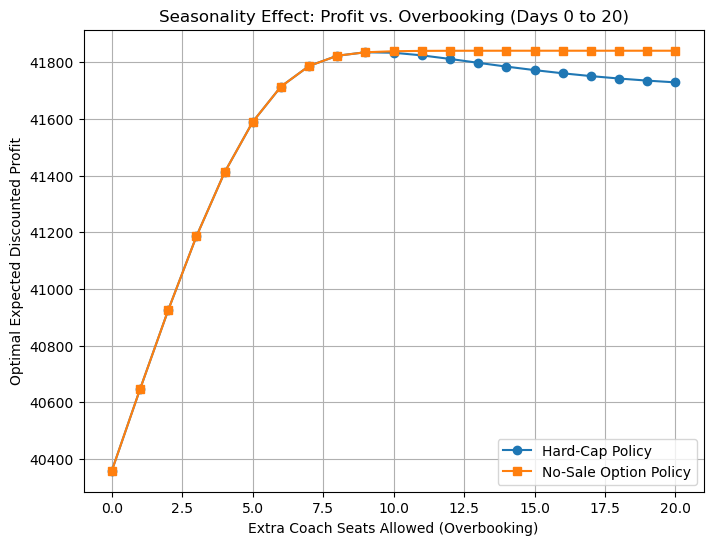

In [45]:

# -------------------------
# 4. Visualization: Line Chart Comparing the Two Models
# -------------------------
plt.figure(figsize=(8, 6))
plt.plot(overbook_values[:len(profits_hardcap_season)], profits_hardcap_season, marker='o', linestyle='-', label='Hard-Cap Policy')
plt.plot(overbook_values[:len(profits_hardcap_season)], profits_no_sale_season, marker='s', linestyle='-', label='No-Sale Option Policy')
plt.xlabel('Extra Coach Seats Allowed (Overbooking)')
plt.ylabel('Optimal Expected Discounted Profit')
plt.title('Seasonality Effect: Profit vs. Overbooking (Days 0 to 20)')
plt.legend()
plt.grid(True)
plt.show()

# Question 5

## Non-Seasonal Outputs: Hard-cap policy + No-sale policy

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# -------------------------
# Parameters (Without Seasonality)
# -------------------------
T = 365                      # Number of days until departure
coach_capacity = 100         # Physical coach capacity
fc_capacity = 20             # First-class capacity (no overbooking allowed)

# Prices and base sale probabilities for coach and first-class
# For coach (hard cap): two options: low ($300) and high ($350)
coach_low_price = 300
coach_high_price = 350
coach_prob_low = 0.65
coach_prob_high = 0.30

# For first-class: two options: low ($425) and high ($500)
fc_low_price = 425
fc_high_price = 500
fc_prob_low = 0.08
fc_prob_high = 0.04

# For no-sale option model, add a third coach decision: "none" (force no sale)
# We'll represent that as ('none', 0, 0.0)

# Show-up probabilities (for computing terminal overbooking cost)
coach_show = 0.95
fc_show = 0.97

# Overbooking cost parameters
cost_bump_fc = 50    # Cost to bump a coach passenger into first-class
cost_bump_off = 425  # Cost to bump a coach passenger off the plane

# Discount factor: given 17% annual discount rate, daily factor is
beta = 1 / (1 + 0.17 / 365)

# Set the chosen overbooking level (extra seats allowed beyond coach_capacity)
overbook = 9  # so maximum coach tickets sold = 100 + 9 = 109

# -------------------------
# DP Solver for Hard-Cap Policy (No No-Sale Option)
# -------------------------
def solve_dp_hardcap_policy(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    
    # Terminal stage: no more sales; incur overbooking costs.
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None

    # Backward induction for days 1 to T
    for t in range(1, T+1):
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                # Two coach pricing options: low and high.
                for (cp, base_p_c) in [(coach_low_price, coach_prob_low), (coach_high_price, coach_prob_high)]:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        p_c = base_p_c
                        if fs == fc_capacity:
                            p_c += 0.03
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f
                        immediate_rev = p_c * cp + p_f * fp
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_sale = V[t-1, min(cs+1, coach_max), fs]
                        v_fc_sale = V[t-1, cs, min(fs+1, fc_capacity)]
                        v_both = V[t-1, min(cs+1, coach_max), min(fs+1, fc_capacity)]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_sale +
                                           (1 - p_c)*p_f*v_fc_sale +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

# -------------------------
# DP Solver for No-Sale Option Policy
# -------------------------
def solve_dp_no_sale_policy(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    
    # Terminal stage remains the same.
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None

    # Backward induction with three coach options: 'none', 'low', 'high'.
    for t in range(1, T+1):
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                coach_decisions = [('none', 0, 0.0),
                                   ('low', coach_low_price, coach_prob_low),
                                   ('high', coach_high_price, coach_prob_high)]
                for (option, cp, base_p_c) in coach_decisions:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        if option == 'none':
                            p_c = 0.0
                        else:
                            p_c = base_p_c
                            if fs == fc_capacity:
                                p_c += 0.03
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f
                        immediate_rev = p_c * cp + p_f * fp
                        new_cs = cs + 1 if (option != 'none' and cs < coach_max) else cs
                        new_fs = fs + 1 if fs < fc_capacity else fs
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_only = V[t-1, new_cs, fs]
                        v_fc_only = V[t-1, cs, new_fs]
                        v_both = V[t-1, new_cs, new_fs]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_only +
                                           (1 - p_c)*p_f*v_fc_only +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (option, cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

# -------------------------
# Simulation Functions (Forward)
# -------------------------
def simulate_forward_hardcap(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0  # coach tickets sold
        fs = 0  # first-class tickets sold
        total_profit = 0.0
        for day in range(1, T+1):
            d = T - day + 1  # DP index for days remaining
            decision = policy[d, cs, fs]  # (cp, fp)
            cp, fp = (0, 0) if decision is None else decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if cp == coach_low_price:
                    p_c = coach_prob_low
                elif cp == coach_high_price:
                    p_c = coach_prob_high
                else:
                    p_c = 0.0
                if fs == fc_capacity:
                    p_c += 0.03
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low
                elif fp == fc_high_price:
                    p_f = fc_prob_high
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach:
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        coach_overbooked = (coach_showups > coach_capacity)
        kicked_off = (bumped_off > 0)
        sim_results.append({
            'profit': total_profit,
            'overbook_cost': overbook_cost,
            'coach_overbooked': coach_overbooked,
            'kicked_off': kicked_off,
            'cs': cs,
            'fs': fs,
            'coach_showups': coach_showups,
            'fc_showups': fc_showups
        })
    return sim_results

def simulate_forward_no_sale(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0
        fs = 0
        total_profit = 0.0
        for day in range(1, T+1):
            d = T - day + 1
            decision = policy[d, cs, fs]  # (option, cp, fp)
            if decision is None:
                option, cp, fp = ('none', 0, 0)
            else:
                option, cp, fp = decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if option == 'none':
                    p_c = 0.0
                elif option == 'low':
                    p_c = coach_prob_low
                elif option == 'high':
                    p_c = coach_prob_high
                else:
                    p_c = 0.0
                if fs == fc_capacity:
                    p_c += 0.03
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low
                elif fp == fc_high_price:
                    p_f = fc_prob_high
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach and option != 'none':
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        coach_overbooked = (coach_showups > coach_capacity)
        kicked_off = (bumped_off > 0)
        sim_results.append({
            'profit': total_profit,
            'overbook_cost': overbook_cost,
            'coach_overbooked': coach_overbooked,
            'kicked_off': kicked_off,
            'cs': cs,
            'fs': fs,
            'coach_showups': coach_showups,
            'fc_showups': fc_showups
        })
    return sim_results

# -------------------------
# New Simulation Function to Record Daily Decisions & Sales for No-Sale Option
# -------------------------
def simulate_forward_no_sale_record(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    # Arrays to record decisions and cumulative sales per simulation
    decisions_record = np.empty((n_sim, T), dtype=object)  # one decision per day per simulation
    cum_coach_sales = np.zeros((n_sim, T+1))
    cum_fc_sales = np.zeros((n_sim, T+1))
    
    for sim in range(n_sim):
        cs = 0
        fs = 0
        cum_coach_sales[sim, 0] = cs
        cum_fc_sales[sim, 0] = fs
        for day in range(1, T+1):
            d = T - day + 1
            decision = policy[d, cs, fs]  # (option, cp, fp)
            if decision is None:
                option, cp, fp = ('none', 0, 0)
            else:
                option, cp, fp = decision
            decisions_record[sim, day-1] = option
            # Determine coach sale probability:
            if cs == coach_max:
                p_c = 0.0
            else:
                if option == 'none':
                    p_c = 0.0
                elif option == 'low':
                    p_c = coach_prob_low
                elif option == 'high':
                    p_c = coach_prob_high
                else:
                    p_c = 0.0
                if fs == fc_capacity:
                    p_c += 0.03
            # Determine first-class sale probability:
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low
                elif fp == fc_high_price:
                    p_f = fc_prob_high
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            if sale_coach and option != 'none' and cs < coach_max:
                cs += 1
            if sale_fc and fs < fc_capacity:
                fs += 1
            cum_coach_sales[sim, day] = cs
            cum_fc_sales[sim, day] = fs
    return decisions_record, cum_coach_sales, cum_fc_sales

# -------------------------
# Run DP Solvers to Get Policies (for overbook = 9)
# -------------------------
V_hard, policy_hard = solve_dp_hardcap_policy(overbook)
V_no_sale, policy_no_sale = solve_dp_no_sale_policy(overbook)

# -------------------------
# Run Simulations (e.g., 1000 forward simulations)
# -------------------------
n_sim = 1000
sim_results_hard = simulate_forward_hardcap(policy_hard, overbook, n_sim)
sim_results_no_sale = simulate_forward_no_sale(policy_no_sale, overbook, n_sim)

# -------------------------
# Process Simulation Results: Hard-Cap Policy
# -------------------------
profits_hard = [res['profit'] for res in sim_results_hard]
overbook_costs_hard = [res['overbook_cost'] for res in sim_results_hard]
coach_overbooked_hard = [res['coach_overbooked'] for res in sim_results_hard]
kicked_off_hard = [res['kicked_off'] for res in sim_results_hard]

print("Hard-Cap Policy Simulation Results:")
print(f"Average Discounted Profit: {np.mean(profits_hard):.2f}")
print(f"Profit Volatility (Std Dev): {np.std(profits_hard):.2f}")
print(f"Average Overbooking Cost: {np.mean(overbook_costs_hard):.2f}")
print(f"Coach Overbooked in {100*np.mean(coach_overbooked_hard):.1f}% of simulations")
print(f"Passengers kicked off in {100*np.mean(kicked_off_hard):.1f}% of simulations")

# -------------------------
# Process Simulation Results: No-Sale Option Policy
# -------------------------
profits_no_sale = [res['profit'] for res in sim_results_no_sale]
overbook_costs_no_sale = [res['overbook_cost'] for res in sim_results_no_sale]
coach_overbooked_no_sale = [res['coach_overbooked'] for res in sim_results_no_sale]
kicked_off_no_sale = [res['kicked_off'] for res in sim_results_no_sale]

print("\nNo-Sale Option Policy Simulation Results:")
print(f"Average Discounted Profit: {np.mean(profits_no_sale):.2f}")
print(f"Profit Volatility (Std Dev): {np.std(profits_no_sale):.2f}")
print(f"Average Overbooking Cost: {np.mean(overbook_costs_no_sale):.2f}")
print(f"Coach Overbooked in {100*np.mean(coach_overbooked_no_sale):.1f}% of simulations")
print(f"Passengers kicked off in {100*np.mean(kicked_off_no_sale):.1f}% of simulations")



Hard-Cap Policy Simulation Results:
Average Discounted Profit: 41686.11
Profit Volatility (Std Dev): 878.68
Average Overbooking Cost: 962.67
Coach Overbooked in 81.3% of simulations
Passengers kicked off in 67.3% of simulations

No-Sale Option Policy Simulation Results:
Average Discounted Profit: 41680.63
Profit Volatility (Std Dev): 893.86
Average Overbooking Cost: 954.48
Coach Overbooked in 79.2% of simulations
Passengers kicked off in 67.0% of simulations


## Non-Seasonal Outputs GRAPHS

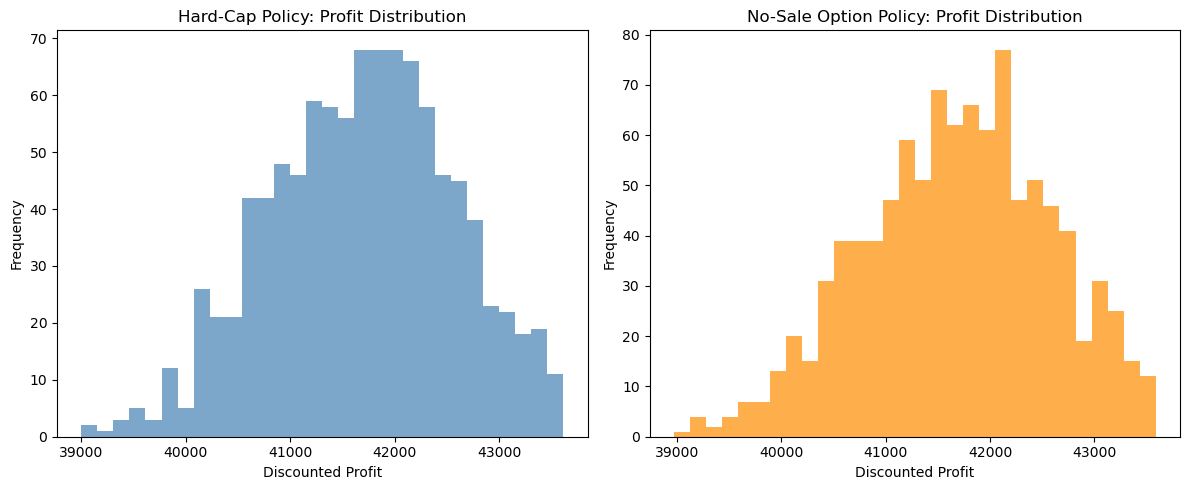

In [24]:

# -------------------------
# Visualization: Histograms and Bar Charts
# -------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(profits_hard, bins=30, alpha=0.7, color='steelblue')
plt.xlabel('Discounted Profit')
plt.ylabel('Frequency')
plt.title('Hard-Cap Policy: Profit Distribution')

plt.subplot(1,2,2)
plt.hist(profits_no_sale, bins=30, alpha=0.7, color='darkorange')
plt.xlabel('Discounted Profit')
plt.ylabel('Frequency')
plt.title('No-Sale Option Policy: Profit Distribution')
plt.tight_layout()
plt.show()

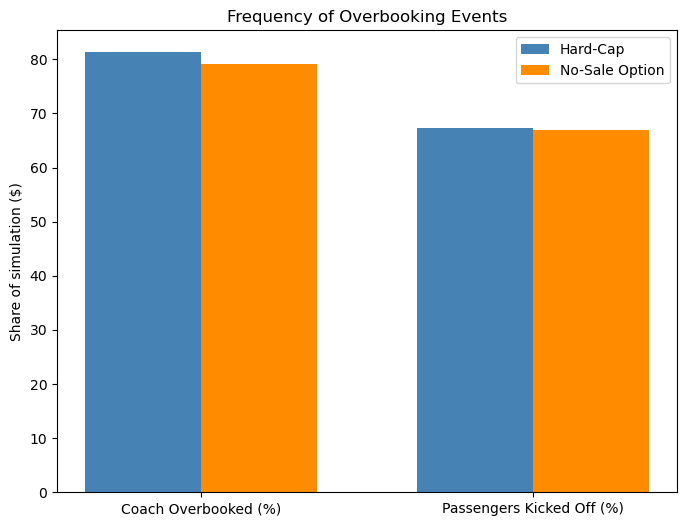

In [27]:


# Bar chart for frequencies
labels = ['Coach Overbooked (%)', 'Passengers Kicked Off (%)']
hard_freq = [100*np.mean(coach_overbooked_hard), 100*np.mean(kicked_off_hard)]
no_sale_freq = [100*np.mean(coach_overbooked_no_sale), 100*np.mean(kicked_off_no_sale)]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, hard_freq, width, label='Hard-Cap', color='steelblue')
plt.bar(x + width/2, no_sale_freq, width, label='No-Sale Option', color='darkorange')
plt.xticks(x, labels)
plt.ylabel('Share of simulation ($)')
plt.title('Frequency of Overbooking Events')
plt.legend()
plt.show()

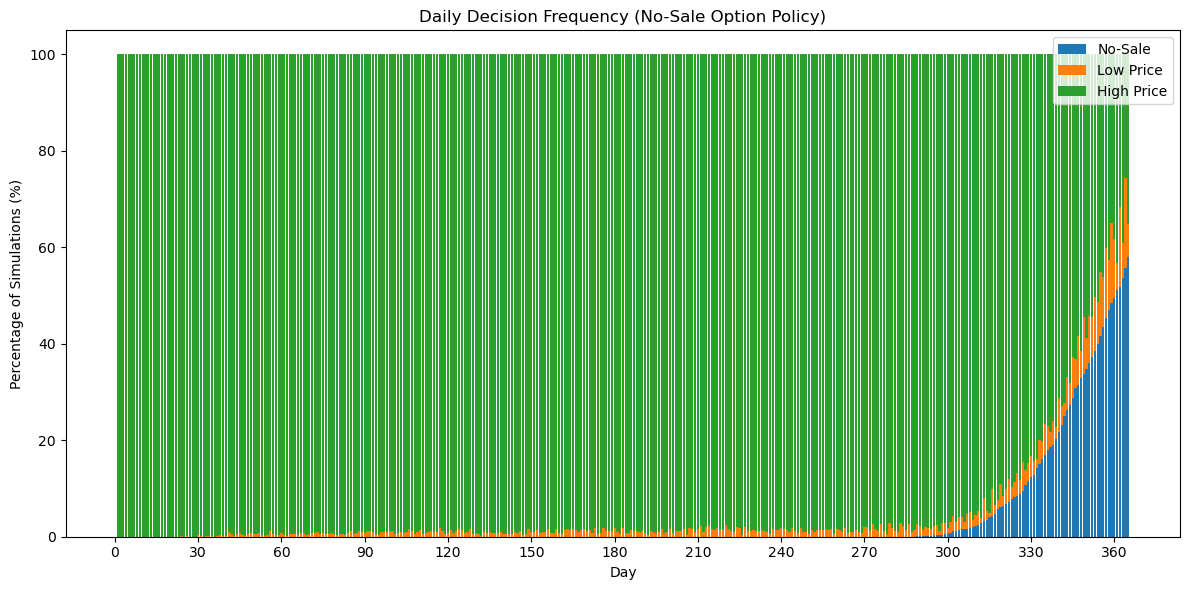

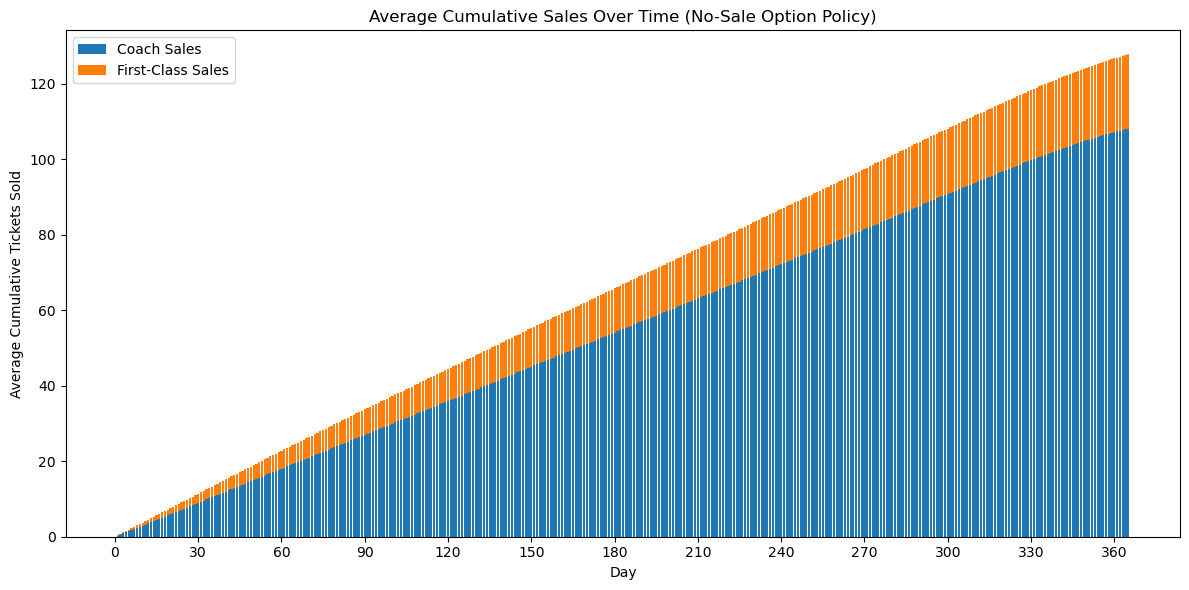

In [29]:
# -------------------------
# New Visualization 1: Daily Decision Frequency Analysis (No-Sale Policy)
# -------------------------
# Run simulation that records daily decisions
decisions_record, cum_coach_sales, cum_fc_sales = simulate_forward_no_sale_record(policy_no_sale, overbook, n_sim)

days = np.arange(1, T+1)
freq_none = np.zeros(T)
freq_low = np.zeros(T)
freq_high = np.zeros(T)
for day in range(T):
    # Extract decisions for current day across simulations
    decisions_day = decisions_record[:, day]
    freq_none[day] = np.mean(decisions_day == 'none') * 100
    freq_low[day] = np.mean(decisions_day == 'low') * 100
    freq_high[day] = np.mean(decisions_day == 'high') * 100

plt.figure(figsize=(12, 6))
plt.bar(days, freq_none, label='No-Sale')
plt.bar(days, freq_low, bottom=freq_none, label='Low Price')
plt.bar(days, freq_high, bottom=freq_none+freq_low, label='High Price')
plt.xlabel('Day')
plt.ylabel('Percentage of Simulations (%)')
plt.title('Daily Decision Frequency (No-Sale Option Policy)')
plt.legend()
plt.xticks(np.arange(0, T+1, 30))
plt.tight_layout()
plt.show()

# -------------------------
# New Visualization 2: Average Cumulative Sales Over Time
# -------------------------
avg_coach = np.mean(cum_coach_sales, axis=0)  # shape (T+1,)
avg_fc = np.mean(cum_fc_sales, axis=0)          # shape (T+1,)

plt.figure(figsize=(12, 6))
plt.bar(np.arange(1, T+1), avg_coach[1:], label='Coach Sales')
plt.bar(np.arange(1, T+1), avg_fc[1:], bottom=avg_coach[1:], label='First-Class Sales')
plt.xlabel('Day')
plt.ylabel('Average Cumulative Tickets Sold')
plt.title('Average Cumulative Sales Over Time (No-Sale Option Policy)')
plt.legend()
plt.xticks(np.arange(0, T+1, 30))
plt.tight_layout()
plt.show()

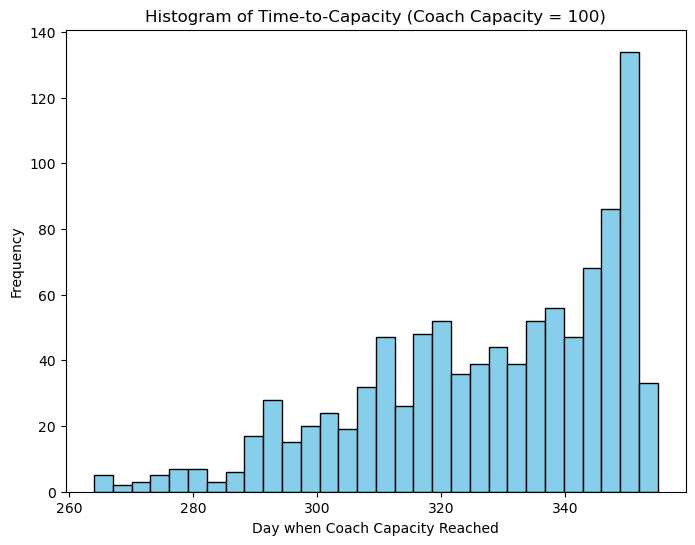

In [33]:

# Compute time-to-full capacity (physical capacity = coach_capacity)
time_to_full_capacity = []
n_sim = cum_coach_sales.shape[0]
for sim in range(n_sim):
    # Find the first day (from day 1 to T) when cumulative coach sales reach or exceed coach_capacity
    days_reached = np.where(cum_coach_sales[sim, 1:] >= coach_capacity)[0]
    if days_reached.size > 0:
        # days_reached indices start at 0 for day 1, so add 1.
        ttc = days_reached[0] + 1
    else:
        # If never reached, assign T+1 (or T)
        ttc = T
    time_to_full_capacity.append(ttc)

time_to_full_capacity = np.array(time_to_full_capacity)

plt.figure(figsize=(8, 6))
plt.hist(time_to_full_capacity, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Day when Coach Capacity Reached')
plt.ylabel('Frequency')
plt.title('Histogram of Time-to-Capacity (Coach Capacity = 100)')
plt.show()


## Seasonality and Non-Seasonal Simulations Outputs

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import pandas as pd

# -------------------------
# COMMON PARAMETERS
# -------------------------
T = 365                      # Number of days until departure
coach_capacity = 100         # Physical coach capacity
fc_capacity = 20             # First-class capacity (no overbooking allowed)

# Prices and base sale probabilities for coach and first-class
# Coach: low = $300, high = $350
coach_low_price = 300
coach_high_price = 350
coach_prob_low = 0.65
coach_prob_high = 0.30

# First-class: low = $425, high = $500
fc_low_price = 425
fc_high_price = 500
fc_prob_low = 0.08
fc_prob_high = 0.04

# For no-sale option, add an extra coach decision: 'none' (0 price, 0 probability)

# Show-up probabilities (for terminal cost)
coach_show = 0.95
fc_show = 0.97

# Overbooking cost parameters
cost_bump_fc = 50    # Cost to bump a coach passenger into first-class
cost_bump_off = 425  # Cost to bump a coach passenger off the plane

# Discount factor (17% annual rate)
beta = 1 / (1 + 0.17 / 365)

# -------------------------
# NON-SEASONALITY DP SOLVERS & SIMULATIONS
# -------------------------
def solve_dp_hardcap_policy(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    # Terminal stage
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None
    # Backward induction
    for t in range(1, T+1):
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                for (cp, base_p_c) in [(coach_low_price, coach_prob_low), (coach_high_price, coach_prob_high)]:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        p_c = base_p_c
                        if fs == fc_capacity:
                            p_c += 0.03
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f
                        immediate_rev = p_c * cp + p_f * fp
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_sale = V[t-1, min(cs+1, coach_max), fs]
                        v_fc_sale = V[t-1, cs, min(fs+1, fc_capacity)]
                        v_both = V[t-1, min(cs+1, coach_max), min(fs+1, fc_capacity)]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_sale +
                                           (1 - p_c)*p_f*v_fc_sale +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

def solve_dp_no_sale_policy(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    # Terminal stage
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None
    # Backward induction with three options: 'none', 'low', 'high'
    for t in range(1, T+1):
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                coach_decisions = [('none', 0, 0.0),
                                   ('low', coach_low_price, coach_prob_low),
                                   ('high', coach_high_price, coach_prob_high)]
                for (option, cp, base_p_c) in coach_decisions:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        if option == 'none':
                            p_c = 0.0
                        else:
                            p_c = base_p_c
                            if fs == fc_capacity:
                                p_c += 0.03
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f
                        immediate_rev = p_c * cp + p_f * fp
                        new_cs = cs + 1 if (option != 'none' and cs < coach_max) else cs
                        new_fs = fs + 1 if fs < fc_capacity else fs
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_only = V[t-1, new_cs, fs]
                        v_fc_only = V[t-1, cs, new_fs]
                        v_both = V[t-1, new_cs, new_fs]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_only +
                                           (1 - p_c)*p_f*v_fc_only +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (option, cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

def simulate_forward_hardcap(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0; fs = 0; total_profit = 0.0
        for day in range(1, T+1):
            d = T - day + 1  # DP index for days remaining
            decision = policy[d, cs, fs]  # (cp, fp)
            cp, fp = (0, 0) if decision is None else decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if cp == coach_low_price:
                    p_c = coach_prob_low
                elif cp == coach_high_price:
                    p_c = coach_prob_high
                else:
                    p_c = 0.0
                if fs == fc_capacity:
                    p_c += 0.03
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low
                elif fp == fc_high_price:
                    p_f = fc_prob_high
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach:
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        # Terminal: simulate no-shows and cost
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        sim_results.append({'profit': total_profit})
    return sim_results

def simulate_forward_no_sale(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0; fs = 0; total_profit = 0.0
        for day in range(1, T+1):
            d = T - day + 1
            decision = policy[d, cs, fs]  # (option, cp, fp)
            if decision is None:
                option, cp, fp = ('none', 0, 0)
            else:
                option, cp, fp = decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if option == 'none':
                    p_c = 0.0
                elif option == 'low':
                    p_c = coach_prob_low
                elif option == 'high':
                    p_c = coach_prob_high
                else:
                    p_c = 0.0
                if fs == fc_capacity:
                    p_c += 0.03
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low
                elif fp == fc_high_price:
                    p_f = fc_prob_high
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach and option != 'none':
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        sim_results.append({'profit': total_profit})
    return sim_results

# -------------------------
# SEASONALITY DP SOLVERS & SIMULATIONS
# -------------------------
# In the seasonality versions we modify the backward induction and simulation so that
# on each day the sales probability is multiplied by a seasonality factor:
#   factor = 0.75 + (day/730)
# In the DP solvers, we use day = T - t + 1 (so that on the final selling day the factor is high).

def solve_dp_hardcap_policy_seasonality(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None
    # Backward induction with seasonality
    for t in range(1, T+1):
        day = T - t + 1  # so day increases as departure nears
        season_factor = 0.75 + day/730.0
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                for (cp, base_p_c) in [(coach_low_price, coach_prob_low), (coach_high_price, coach_prob_high)]:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        # Multiply base probability (plus boost if fc full) by season_factor
                        if fs == fc_capacity:
                            p_c = (base_p_c + 0.03) * season_factor
                        else:
                            p_c = base_p_c * season_factor
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f * season_factor
                        immediate_rev = p_c * cp + p_f * fp
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_sale = V[t-1, min(cs+1, coach_max), fs]
                        v_fc_sale = V[t-1, cs, min(fs+1, fc_capacity)]
                        v_both = V[t-1, min(cs+1, coach_max), min(fs+1, fc_capacity)]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_sale +
                                           (1 - p_c)*p_f*v_fc_sale +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

def solve_dp_no_sale_policy_seasonality(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None
    for t in range(1, T+1):
        day = T - t + 1
        season_factor = 0.75 + day/730.0
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                coach_decisions = [('none', 0, 0.0),
                                   ('low', coach_low_price, coach_prob_low),
                                   ('high', coach_high_price, coach_prob_high)]
                for (option, cp, base_p_c) in coach_decisions:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        if option == 'none':
                            p_c = 0.0
                        else:
                            if fs == fc_capacity:
                                p_c = (base_p_c + 0.03) * season_factor
                            else:
                                p_c = base_p_c * season_factor
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f * season_factor
                        immediate_rev = p_c * cp + p_f * fp
                        new_cs = cs + 1 if (option != 'none' and cs < coach_max) else cs
                        new_fs = fs + 1 if fs < fc_capacity else fs
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_only = V[t-1, new_cs, fs]
                        v_fc_only = V[t-1, cs, new_fs]
                        v_both = V[t-1, new_cs, new_fs]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_only +
                                           (1 - p_c)*p_f*v_fc_only +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (option, cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

def simulate_forward_hardcap_seasonality(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0; fs = 0; total_profit = 0.0
        for day in range(1, T+1):
            # Use actual day index (1...T) for seasonality factor
            
            season_factor = 0.75 + day/730.0
            d = T - day + 1
            decision = policy[d, cs, fs]
            cp, fp = (0, 0) if decision is None else decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if cp == coach_low_price:
                    base = coach_prob_low
                elif cp == coach_high_price:
                    base = coach_prob_high
                else:
                    base = 0.0
                if fs == fc_capacity:
                    base += 0.03
                p_c = base * season_factor
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low * season_factor
                elif fp == fc_high_price:
                    p_f = fc_prob_high * season_factor
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach:
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        sim_results.append({'profit': total_profit})
    return sim_results

def simulate_forward_no_sale_seasonality(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0; fs = 0; total_profit = 0.0
        for day in range(1, T+1):
            d = T - day + 1
            season_factor = 0.75 + d/730.0
            
            decision = policy[d, cs, fs]  # (option, cp, fp)
            if decision is None:
                option, cp, fp = ('none', 0, 0)
            else:
                option, cp, fp = decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if option == 'none':
                    p_c = 0.0
                elif option == 'low':
                    base = coach_prob_low
                elif option == 'high':
                    base = coach_prob_high
                else:
                    base = 0.0
                if cs < coach_max:
                    if fs == fc_capacity:
                        base += 0.03
                p_c = base * season_factor
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low * season_factor
                elif fp == fc_high_price:
                    p_f = fc_prob_high * season_factor
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach and option != 'none':
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        sim_results.append({'profit': total_profit})
    return sim_results

# -------------------------
# RUN NON-SEASONALITY SIMULATIONS
# -------------------------
n_sim = 1000
# For non-seasonality, we use overbook=9 for both policies.
V_hard, policy_hard = solve_dp_hardcap_policy(overbook=9)
V_no_sale, policy_no_sale = solve_dp_no_sale_policy(overbook=9)

non_season_hard_results = simulate_forward_hardcap(policy_hard, overbook=9, n_sim=n_sim)
non_season_no_sale_results = simulate_forward_no_sale(policy_no_sale, overbook=9, n_sim=n_sim)

avg_profit_non_hard = np.mean([r['profit'] for r in non_season_hard_results])
vol_profit_non_hard = np.std([r['profit'] for r in non_season_hard_results])
avg_profit_non_no_sale = np.mean([r['profit'] for r in non_season_no_sale_results])
vol_profit_non_no_sale = np.std([r['profit'] for r in non_season_no_sale_results])

# -------------------------
# RUN SEASONALITY SIMULATIONS
# -------------------------
# According to the specification, for seasonality:
#   - Hard Cap uses overbook=9
#   - No Sale uses overbook=16
V_hard_season, policy_hard_season = solve_dp_hardcap_policy_seasonality(overbook=9)
V_no_sale_season, policy_no_sale_season = solve_dp_no_sale_policy_seasonality(overbook=16)

season_hard_results = simulate_forward_hardcap_seasonality(policy_hard_season, overbook=9, n_sim=n_sim)
season_no_sale_results = simulate_forward_no_sale_seasonality(policy_no_sale_season, overbook=16, n_sim=n_sim)

avg_profit_season_hard = np.mean([r['profit'] for r in season_hard_results])
vol_profit_season_hard = np.std([r['profit'] for r in season_hard_results])
avg_profit_season_no_sale = np.mean([r['profit'] for r in season_no_sale_results])
vol_profit_season_no_sale = np.std([r['profit'] for r in season_no_sale_results])

# -------------------------
# CREATE SUMMARY TABLES
# -------------------------
# Table 1: Average Discounted Profit
avg_profit_df = pd.DataFrame({
    "Non-Seasonality": [avg_profit_non_hard, avg_profit_non_no_sale],
    "Seasonality": [avg_profit_season_hard, avg_profit_season_no_sale]
}, index=["Hard Cap", "No Sale"])

# Table 2: Annual Profit Volatility (Std Dev)
volatility_df = pd.DataFrame({
    "Non-Seasonality": [vol_profit_non_hard, vol_profit_non_no_sale],
    "Seasonality": [vol_profit_season_hard, vol_profit_season_no_sale]
}, index=["Hard Cap", "No Sale"])

print("Average Discounted Profit:")
print(avg_profit_df)
print("\nProfit Volatility (Std Dev):")
print(volatility_df)

Average Discounted Profit:
          Non-Seasonality   Seasonality
Hard Cap     41681.941201  41976.264187
No Sale      41630.487001  41352.244930

Profit Volatility (Std Dev):
          Non-Seasonality  Seasonality
Hard Cap       893.000540   884.401530
No Sale        888.187612   951.900576


## Seasonal Outputs: Hard-cap seasonality and no-sale seasonality

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import pandas as pd

# -------------------------
# COMMON PARAMETERS
# -------------------------
T = 365                      # Number of days until departure
n_sim = 1000                # Number of simulations
coach_capacity = 100         # Physical coach capacity
fc_capacity = 20             # First-class capacity (no overbooking allowed)

# Prices and base sale probabilities for coach and first-class
# Coach: low = $300, high = $350
coach_low_price = 300
coach_high_price = 350
coach_prob_low = 0.65
coach_prob_high = 0.30

# First-class: low = $425, high = $500
fc_low_price = 425
fc_high_price = 500
fc_prob_low = 0.08
fc_prob_high = 0.04

# Show-up probabilities (for terminal cost)
coach_show = 0.95
fc_show = 0.97

# Overbooking cost parameters
cost_bump_fc = 50    # Cost to bump a coach passenger into first-class
cost_bump_off = 425  # Cost to bump a coach passenger off the plane

# Discount factor (17% annual rate)
beta = 1 / (1 + 0.17 / 365)

# -------------------------
# DP SOLVERS WITH SEASONALITY
# -------------------------
def solve_dp_hardcap_policy_seasonality(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None
    for t in range(1, T+1):
        day = T - t + 1
        season_factor = 0.75 + day/730.0
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                for (cp, base_p_c) in [(coach_low_price, coach_prob_low), (coach_high_price, coach_prob_high)]:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        if fs == fc_capacity:
                            p_c = (base_p_c + 0.03) * season_factor
                        else:
                            p_c = base_p_c * season_factor
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f * season_factor
                        immediate_rev = p_c * cp + p_f * fp
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_sale = V[t-1, min(cs+1, coach_max), fs]
                        v_fc_sale = V[t-1, cs, min(fs+1, fc_capacity)]
                        v_both = V[t-1, min(cs+1, coach_max), min(fs+1, fc_capacity)]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_sale +
                                           (1 - p_c)*p_f*v_fc_sale +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

def solve_dp_no_sale_policy_seasonality(overbook):
    coach_max = coach_capacity + overbook
    V = np.zeros((T+1, coach_max+1, fc_capacity+1))
    policy = np.empty((T+1, coach_max+1, fc_capacity+1), dtype=object)
    for cs in range(coach_max+1):
        for fs in range(fc_capacity+1):
            expected_cost = 0.0
            for x in range(cs+1):
                p_x = binom.pmf(x, cs, coach_show)
                for y in range(fs+1):
                    p_y = binom.pmf(y, fs, fc_show)
                    extra = max(x - coach_capacity, 0)
                    available_fc = max(fc_capacity - y, 0)
                    bumped_to_fc = min(extra, available_fc)
                    bumped_off = extra - bumped_to_fc
                    cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
                    expected_cost += p_x * p_y * cost
            V[0, cs, fs] = -expected_cost
            policy[0, cs, fs] = None
    for t in range(1, T+1):
        day = T - t + 1
        season_factor = 0.75 + day/730.0
        for cs in range(coach_max+1):
            for fs in range(fc_capacity+1):
                best_value = -np.inf
                best_decision = None
                coach_decisions = [('none', 0, 0.0),
                                   ('low', coach_low_price, coach_prob_low),
                                   ('high', coach_high_price, coach_prob_high)]
                for (option, cp, base_p_c) in coach_decisions:
                    if cs == coach_max:
                        p_c = 0.0
                    else:
                        if option == 'none':
                            p_c = 0.0
                        else:
                            if fs == fc_capacity:
                                p_c = (base_p_c + 0.03) * season_factor
                            else:
                                p_c = base_p_c * season_factor
                    for (fp, base_p_f) in [(fc_low_price, fc_prob_low), (fc_high_price, fc_prob_high)]:
                        p_f = 0.0 if fs == fc_capacity else base_p_f * season_factor
                        immediate_rev = p_c * cp + p_f * fp
                        new_cs = cs + 1 if (option != 'none' and cs < coach_max) else cs
                        new_fs = fs + 1 if fs < fc_capacity else fs
                        v_no_sale = V[t-1, cs, fs]
                        v_coach_only = V[t-1, new_cs, fs]
                        v_fc_only = V[t-1, cs, new_fs]
                        v_both = V[t-1, new_cs, new_fs]
                        expected_future = ((1 - p_c)*(1 - p_f)*v_no_sale +
                                           p_c*(1 - p_f)*v_coach_only +
                                           (1 - p_c)*p_f*v_fc_only +
                                           p_c*p_f*v_both)
                        total_value = immediate_rev + beta * expected_future
                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (option, cp, fp)
                V[t, cs, fs] = best_value
                policy[t, cs, fs] = best_decision
    return V, policy

# -------------------------
# SIMULATION FUNCTIONS (SEASONALITY)
# -------------------------
def simulate_forward_hardcap_seasonality(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0; fs = 0; total_profit = 0.0
        for day in range(1, T+1):
            season_factor = 0.75 + day/730.0
            d = T - day + 1
            decision = policy[d, cs, fs]
            cp, fp = (0, 0) if decision is None else decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if cp == coach_low_price:
                    base = coach_prob_low
                elif cp == coach_high_price:
                    base = coach_prob_high
                else:
                    base = 0.0
                if fs == fc_capacity:
                    base += 0.03
                p_c = base * season_factor
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low * season_factor
                elif fp == fc_high_price:
                    p_f = fc_prob_high * season_factor
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach:
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        sim_results.append({
            'profit': total_profit,
            'overbook_cost': overbook_cost,
            'coach_overbooked': 1 if extra > 0 else 0,
            'kicked_off': 1 if bumped_off > 0 else 0
        })
    return sim_results

def simulate_forward_no_sale_seasonality(policy, overbook, n_sim=1000):
    coach_max = coach_capacity + overbook
    sim_results = []
    for sim in range(n_sim):
        cs = 0; fs = 0; total_profit = 0.0
        for day in range(1, T+1):
            d = T - day + 1
            season_factor = 0.75 + d/730.0
            decision = policy[d, cs, fs]
            if decision is None:
                option, cp, fp = ('none', 0, 0)
            else:
                option, cp, fp = decision
            if cs == coach_max:
                p_c = 0.0
            else:
                if option == 'none':
                    p_c = 0.0
                elif option == 'low':
                    base = coach_prob_low
                elif option == 'high':
                    base = coach_prob_high
                else:
                    base = 0.0
                if cs < coach_max:
                    if fs == fc_capacity:
                        base += 0.03
                p_c = base * season_factor
            if fs == fc_capacity:
                p_f = 0.0
            else:
                if fp == fc_low_price:
                    p_f = fc_prob_low * season_factor
                elif fp == fc_high_price:
                    p_f = fc_prob_high * season_factor
                else:
                    p_f = 0.0
            sale_coach = (np.random.rand() < p_c)
            sale_fc = (np.random.rand() < p_f)
            rev = 0
            if sale_coach and option != 'none':
                rev += cp
                if cs < coach_max:
                    cs += 1
            if sale_fc:
                rev += fp
                if fs < fc_capacity:
                    fs += 1
            discount_factor = beta ** (T - day + 1)
            total_profit += discount_factor * rev
        coach_showups = np.random.binomial(cs, coach_show)
        fc_showups = np.random.binomial(fs, fc_show)
        extra = max(coach_showups - coach_capacity, 0)
        available_fc = max(fc_capacity - fc_showups, 0)
        bumped_to_fc = min(extra, available_fc)
        bumped_off = extra - bumped_to_fc
        overbook_cost = bumped_to_fc * cost_bump_fc + bumped_off * cost_bump_off
        total_profit -= overbook_cost
        sim_results.append({
            'profit': total_profit,
            'overbook_cost': overbook_cost,
            'coach_overbooked': 1 if extra > 0 else 0,
            'kicked_off': 1 if bumped_off > 0 else 0
        })
    return sim_results

# -------------------------
# RUN SEASONALITY SIMULATIONS
# -------------------------
V_hard_season, policy_hard_season = solve_dp_hardcap_policy_seasonality(overbook=9)
V_no_sale_season, policy_no_sale_season = solve_dp_no_sale_policy_seasonality(overbook=16)

season_hard_results = simulate_forward_hardcap_seasonality(policy_hard_season, overbook=9, n_sim=n_sim)
season_no_sale_results = simulate_forward_no_sale_seasonality(policy_no_sale_season, overbook=16, n_sim=n_sim)

# Unpack metrics
profits_season_hard = [r['profit'] for r in season_hard_results]
overbook_costs_season_hard = [r['overbook_cost'] for r in season_hard_results]
coach_overbooked_season_hard = [r['coach_overbooked'] for r in season_hard_results]
kicked_off_season_hard = [r['kicked_off'] for r in season_hard_results]

profits_season_no_sale = [r['profit'] for r in season_no_sale_results]
overbook_costs_season_no_sale = [r['overbook_cost'] for r in season_no_sale_results]
coach_overbooked_season_no_sale = [r['coach_overbooked'] for r in season_no_sale_results]
kicked_off_season_no_sale = [r['kicked_off'] for r in season_no_sale_results]

# Compute statistics
avg_profit_season_hard = np.mean(profits_season_hard)
vol_profit_season_hard = np.std(profits_season_hard)
avg_overbook_cost_season_hard = np.mean(overbook_costs_season_hard)
pct_overbooked_season_hard = 100 * np.mean(coach_overbooked_season_hard)
pct_kicked_off_season_hard = 100 * np.mean(kicked_off_season_hard)

avg_profit_season_no_sale = np.mean(profits_season_no_sale)
vol_profit_season_no_sale = np.std(profits_season_no_sale)
avg_overbook_cost_season_no_sale = np.mean(overbook_costs_season_no_sale)
pct_overbooked_season_no_sale = 100 * np.mean(coach_overbooked_season_no_sale)
pct_kicked_off_season_no_sale = 100 * np.mean(kicked_off_season_no_sale)

# Print results
print("\n--- Hard-Cap Policy with Seasonality ---")
print(f"Average Discounted Profit: {avg_profit_season_hard:.2f}")
print(f"Profit Volatility (Std Dev): {vol_profit_season_hard:.2f}")
print(f"Average Overbooking Cost: {avg_overbook_cost_season_hard:.2f}")
print(f"Coach Overbooked in {pct_overbooked_season_hard:.1f}% of simulations")
print(f"Passengers kicked off in {pct_kicked_off_season_hard:.1f}% of simulations")

print("\n--- No-Sale Policy with Seasonality ---")
print(f"Average Discounted Profit: {avg_profit_season_no_sale:.2f}")
print(f"Profit Volatility (Std Dev): {vol_profit_season_no_sale:.2f}")
print(f"Average Overbooking Cost: {avg_overbook_cost_season_no_sale:.2f}")
print(f"Coach Overbooked in {pct_overbooked_season_no_sale:.1f}% of simulations")
print(f"Passengers kicked off in {pct_kicked_off_season_no_sale:.1f}% of simulations")



--- Hard-Cap Policy with Seasonality ---
Average Discounted Profit: 42001.01
Profit Volatility (Std Dev): 882.91
Average Overbooking Cost: 958.80
Coach Overbooked in 79.2% of simulations
Passengers kicked off in 69.2% of simulations

--- No-Sale Policy with Seasonality ---
Average Discounted Profit: 41369.58
Profit Volatility (Std Dev): 961.37
Average Overbooking Cost: 790.08
Coach Overbooked in 74.1% of simulations
Passengers kicked off in 56.4% of simulations


## Seasonal GRAPHS

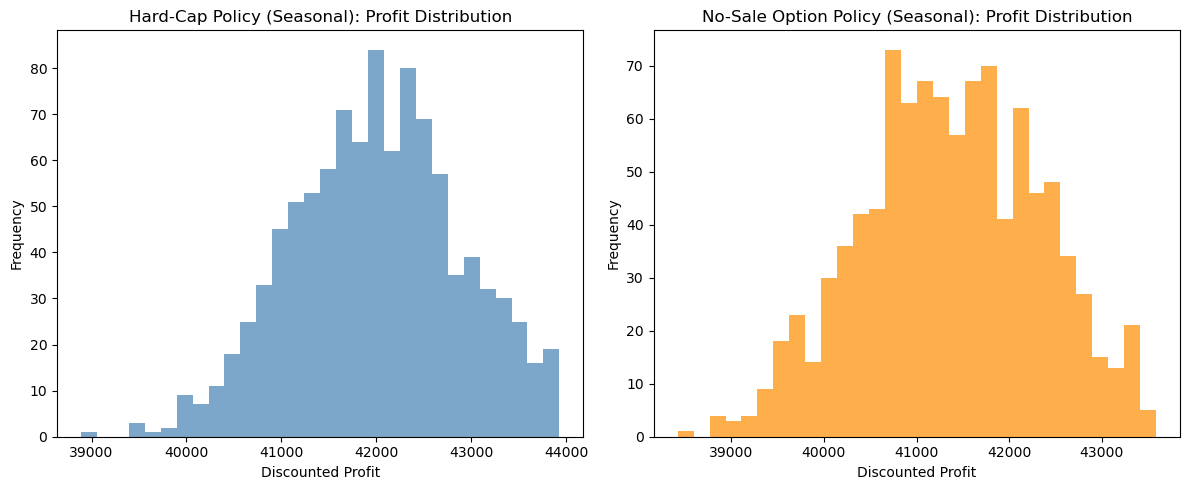

In [58]:
# -------------------------
# Visualization: Histograms and Bar Charts (Seasonal)
# -------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(profits_season_hard, bins=30, alpha=0.7, color='steelblue')
plt.xlabel('Discounted Profit')
plt.ylabel('Frequency')
plt.title('Hard-Cap Policy (Seasonal): Profit Distribution')

plt.subplot(1, 2, 2)
plt.hist(profits_season_no_sale, bins=30, alpha=0.7, color='darkorange')
plt.xlabel('Discounted Profit')
plt.ylabel('Frequency')
plt.title('No-Sale Option Policy (Seasonal): Profit Distribution')

plt.tight_layout()
plt.show()


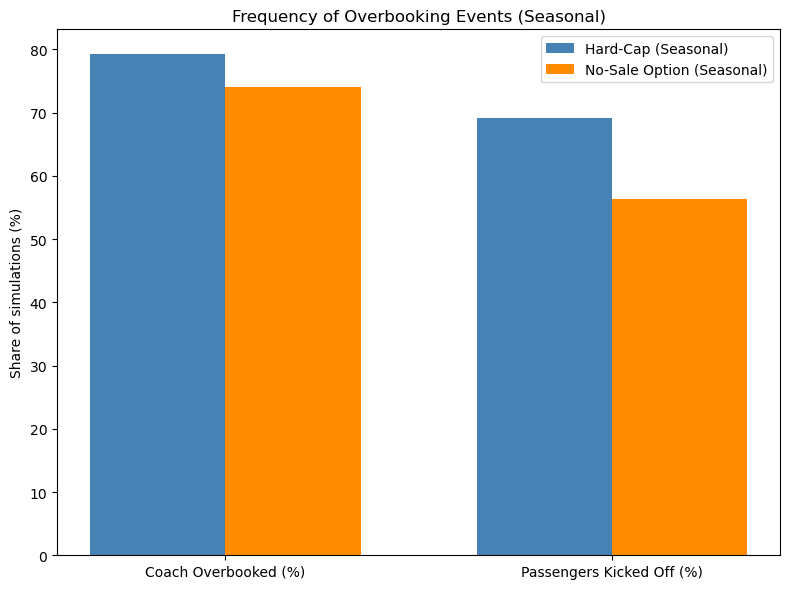

In [56]:
# Bar chart for frequencies (SEASONAL)
labels = ['Coach Overbooked (%)', 'Passengers Kicked Off (%)']
hard_freq_season = [pct_overbooked_season_hard, pct_kicked_off_season_hard]
no_sale_freq_season = [pct_overbooked_season_no_sale, pct_kicked_off_season_no_sale]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, hard_freq_season, width, label='Hard-Cap (Seasonal)', color='steelblue')
plt.bar(x + width/2, no_sale_freq_season, width, label='No-Sale Option (Seasonal)', color='darkorange')
plt.xticks(x, labels)
plt.ylabel('Share of simulations (%)')
plt.title('Frequency of Overbooking Events (Seasonal)')
plt.legend()
plt.tight_layout()
plt.show()
